In [59]:
%load_ext autoreload
%autoreload 2

import os
import preprocessing
from gensim import corpora

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
import os
from gensim.models.doc2vec import TaggedDocument

def texts_corpus(textdir='data/texts/'):
    files = os.listdir(textdir)
    corpus = []
    source_enum = {}
    for i, file in enumerate(files):
        if '.txt' not in file:
            #print('Skipping index: ' + str(i))
            continue
        with open(textdir + file) as f:
            t = f.read()
            #yield gensim.utils.simple_preprocess(t.replace('\n', ' '))
            corpus.append(
                TaggedDocument(
                    #words=[word.lower() for word in t.replace('\n', ' ').split()],
                    words=preprocessing.doc_preprocessor(t, lemmatize=False),
                    tags=[file.strip('.txt')])
                    #tags=[i])
            )
        source_enum[i] = file.strip('.txt')
            
    return corpus, source_enum
            
train_corpus, source_enum = texts_corpus()

In [143]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=100, min_count=2, epochs=100)
model.build_vocab(train_corpus)

%time model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)
#model.save('data/doc2vec.model')

CPU times: user 1h 2min 23s, sys: 14.7 s, total: 1h 2min 37s
Wall time: 22min 3s


In [211]:
fu_dict = {
    paper['id'].split('/')[-1]: paper \
    for paper in preprocessing.flat_unique()
}
id_term = {}
for key in fu_dict.keys():
    id_term[key] = [
        tag['term'].split('.')[1] for tag in fu_dict[key]['tags'] \
         if tag['term'].split('.')[0] == 'q-fin'
    ][0]

In [212]:
#set(id_term.values())
colors = {
    'CP': 'red', 'EC': 'blue', 
    'GN': 'green', 'MF': 'grey', 
    'PM': 'black', 'PR': 'yellow',
    'RM': 'violet', 'ST': 'orange',
    'TR': 'pink'}

In [240]:
import networkx as nx
import matplotlib.pyplot as plt
from pprint import pprint
from tqdm import tqdm

G = nx.Graph()

#for i in tqdm(range(0, len(model.docvecs), 10)):
for i in range(0, len(model.docvecs), 10):
    ivec = model.infer_vector(doc_words=train_corpus[i].words)
    sims = model.docvecs.most_similar([ivec], topn=len(model.docvecs))
    
    this_node = sims[0][0]
    #for j in range(1, len(sims)):
    for j in range(1, 10):
        # Add most similar distance
        G.add_edge(this_node, sims[j][0], 
                   attr_dict={
                       'distance': (1-sims[j][1]), 
                       'color': colors[id_term[sims[j][0]]]
                   })
        # Add least similar distance
        G.add_edge(this_node, sims[-j][0], 
                   attr_dict={
                       'distance': (1-sims[-j][1]), 
                       'color': colors[id_term[sims[-j][0]]]
                   })

In [241]:
edge_colors = [e[2]['attr_dict']['color'] for e in G.edges(data=True)]
node_ids = [e[0] for e in G.nodes(data=True)]
node_colors = [colors[id_term[node_id]] for node_id in node_ids]

In [242]:
pprint(sims[:5])
pprint(sims[:-6:-1])

[('1210.2617v1', 0.9957143068313599),
 ('1110.3897v2', 0.6689179539680481),
 ('1004.3310v3', 0.6476446390151978),
 ('1106.1395v2', 0.6328984498977661),
 ('1810.07674v2', 0.6172880530357361)]
[('1810.09063v2', -0.24884332716464996),
 ('0912.0434v2', -0.16959986090660095),
 ('1702.02254v1', -0.11823306977748871),
 ('1901.01486v1', -0.10960125178098679),
 ('1104.5272v3', -0.1021333783864975)]


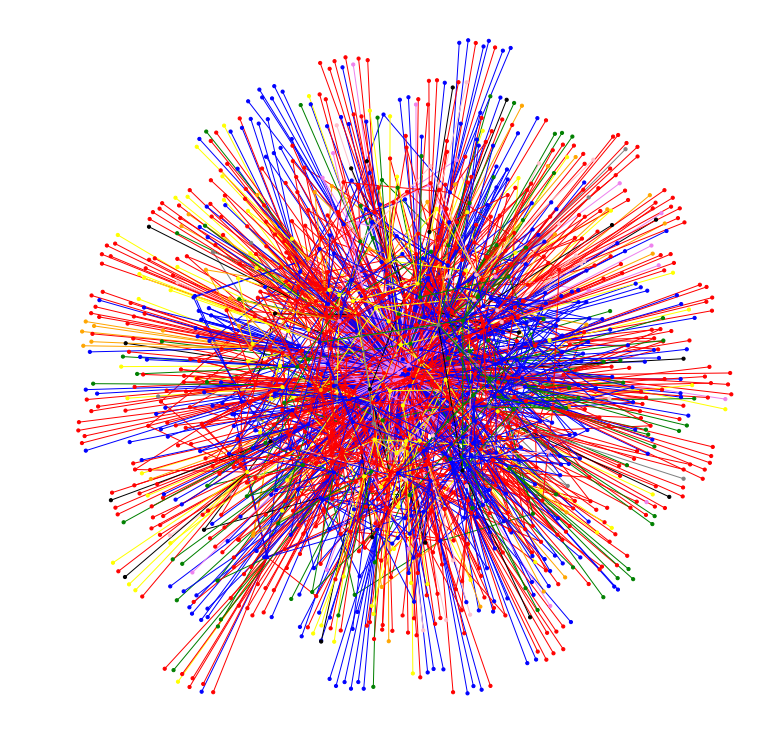

In [245]:
plt.figure(figsize=(10, 10))
nx.draw(G, edge_color=edge_colors, node_color=node_colors, node_size=15)
plt.savefig('data/graph_smallsample.jpg')
plt.show()

In [168]:
'''https://plot.ly/python/network-graphs/#create-network-graph'''
import plotly.plotly as py
import plotly.graph_objs as go

edge_trace = go.Scatter(
    x=[],
    y=[],
    line=dict(width=0.5,color='#888'),
    hoverinfo='none',
    mode='lines')

for edge in G.edges():
    x0, y0 = G.node[edge[0]]['pos']
    x1, y1 = G.node[edge[1]]['pos']
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])

KeyError: 'pos'

In [ ]:
node_trace = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=2)))

for node in G.nodes():
    x, y = G.node[node]['pos']
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])
    
for node, adjacencies in enumerate(G.adjacency()):
    node_trace['marker']['color']+=tuple([len(adjacencies[1])])
    node_info = '# of connections: '+str(len(adjacencies[1]))
    node_trace['text']+=tuple([node_info])
    
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Network graph made with Python',
                titlefont=dict(size=16),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="Python code: <a href='https://plot.ly/ipython-notebooks/network-graphs/'> https://plot.ly/ipython-notebooks/network-graphs/</a>",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

py.iplot(fig, filename='networkx')